***
# 二. 数据分析与可视化

## （一）数据预处理

***

> **先检测爬取的数据中是否有缺失数据，并将各省会城市2014/01/01-2023/12/31每日AQI相关数据整合成年度数据(总统计结果.csv)：**

In [18]:
import pandas as pd
import os

# 获取当前工作目录
script_dir = os.getcwd()

# 指定CSV文件所在的文件夹路径
folder_path = '../AllData/'

# 获取所有CSV文件
csv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

# 创建一个空的DataFrame，用于存储合并的结果
merged_result = pd.DataFrame()

indexs= 0

# 处理每个CSV文件
for csv_file in csv_files:
    # 读取CSV文件
    data = pd.read_csv(csv_file, parse_dates=['time_point'])

    # 提取年份
    data['年份'] = data['time_point'].dt.year

    # 提取城市名
    city_name = os.path.splitext(os.path.basename(csv_file))[0]
    
        # 检测缺失数据
    missing_data = data.isnull().sum()

    # 打印缺失数据情况
    if indexs == 0:
        print("文件中存在缺失数据。")
        print("缺失数据统计：")
        print(missing_data)
        indexs += 1
       


    data['城市'] = city_name

    # 按年统计平均AQI
    annual_avg_aqi = data.groupby(['城市', '年份'])['aqi'].mean()

    # 按年统计各空气质量等级天数
    annual_quality_counts = data.groupby(['城市', '年份', 'quality']).size().unstack(fill_value=0)

    # 重新排列列的顺序
    desired_order = ['优', '良', '轻度污染', '中度污染', '重度污染']
    annual_quality_counts = annual_quality_counts.reindex(columns=desired_order, fill_value=0)

    # 保存结果到新的CSV文件
    result_df = pd.DataFrame({'平均AQI': annual_avg_aqi})
    result_df = pd.concat([result_df, annual_quality_counts], axis=1)
    merged_result = pd.concat([merged_result, result_df])

# 保存最终的合并结果到CSV文件
final_output_path = os.path.join(script_dir, '总统计结果.csv')
merged_result.to_csv(final_output_path, encoding='utf-8', index=True)



文件中存在缺失数据。
缺失数据统计：
time_point     0
aqi            0
pm2_5          0
pm10           0
so2            0
no2            0
co             0
o3             0
rank          30
quality        0
年份             0
dtype: int64


**可以看出每个省会城市AQI数据中缺失只有rank索引对应的数据（该数据是各省会城市日AQI等级的全国排名，可以通过各省会城市日AQI的值间接计算出来）**

**也就相当于AQI数据是无缺失的，无需对缺失数据项额外处理**
 
> **各省会城市AQI年度历史数据特征查看：**

In [8]:
merged_result # 显示部分结果

平均AQI    优    良  轻度污染  中度污染  重度污染
城市 年份                                         
上海 2014  80.457534   64  219    59    18     5
   2015  88.572603   58  197    78    25     7
   2016  80.819672   72  201    73    18     2
   2017  83.630137   62  208    74    18     3
   2018  70.065753  115  193    48     6     2
...            ...  ...  ...   ...   ...   ...
长沙 2019  83.589041   76  199    69    13     8
   2020  70.775956  123  187    47     9     0
   2021  75.613699   95  209    47     7     7
   2022  71.391781  116  186    57     4     2
   2023  71.513736  109  211    30     7     7

[310 rows x 6 columns]

> **各省会城市实时AQI数据查看:**

In [11]:
history_data = pd.read_csv('../realtimeDataFetch/realtimeData.csv')
history_data.head()

,City,Date,AQI,weather,level,PM2.5,PM10,NO2,CO,SO2,O3,temperature,humidity,visibility,wind
0,北京,2024-01-18 16:00:00,108,晴转多云,二级,67,88,45.0,0.9,5.0,24.375,2.1,53,10,235.0
1,天津,2024-01-18 16:00:00,68,晴转多云,一级,18,33,34.0,0.8,11.0,40.625,2.9,46,10,170.0
2,上海,2024-01-18 16:00:00,82,小雨,二级,44,52,49.0,1.1,7.0,11.500,8.9,90,10,92.0
3,重庆,2024-01-18 16:00:00,52,小雨,一级,34,47,32.0,1.0,8.0,14.125,14.2,76,10,93.0
4,石家庄,2024-01-18 16:00:00,133,多云转阴,三级,91,110,38.0,0.8,2.0,15.000,1.6,77,10,312.0


***
## （二） 数据可视化

 ###   ① **Matplotlib初步可视化**

> + **2014年至2023年期间各省会城市年平均AQI变化折线图：**


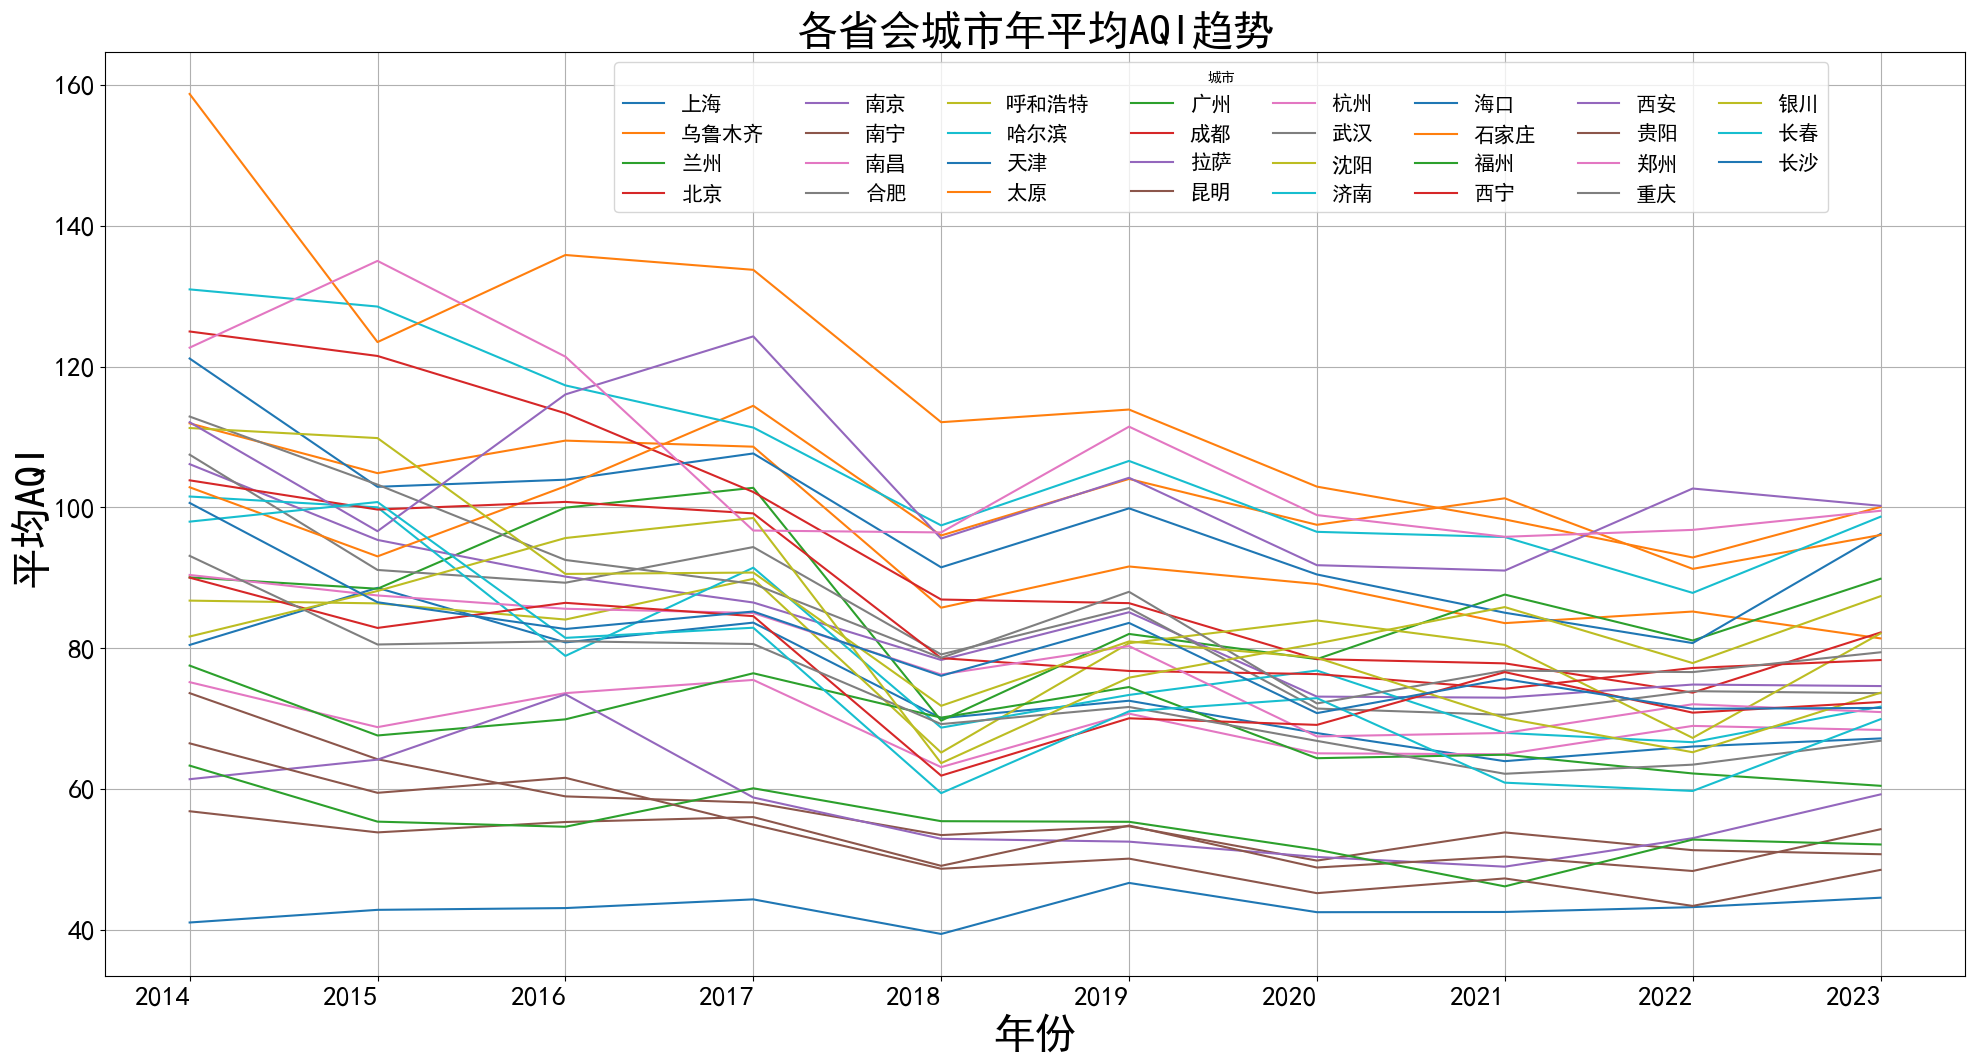

In [15]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


# 获取当前工作目录
script_dir = os.getcwd()

# 读取总统计结果CSV文件
result_path = os.path.join(script_dir, '总统计结果.csv')
merged_result = pd.read_csv(result_path)

# 提取城市名列表
cities = merged_result['城市'].unique()

# 创建一个图表
plt.figure(figsize=(24, 12))

# 指定中文字体为'SIMHEI'
font = FontProperties(fname=r"c:\windows\fonts\SIMHEI.ttf", size=30)

# 绘制每个城市的折线图
for city in cities:
    city_data = merged_result[merged_result['城市'] == city]
    plt.plot(city_data['年份'], city_data['平均AQI'], label=city)
    
# 自定义横坐标刻度为2014、2015、2016...
years = merged_result['年份'].unique()
plt.xticks(years, [str(year) for year in years], ha='right', fontproperties=font, fontsize=20)

# 修改纵坐标刻度字体大小
plt.yticks(fontsize=20)

# 添加标签和标题
plt.xlabel('年份', fontproperties=font)
plt.ylabel('平均AQI', fontproperties=font)
plt.title('各省会城市年平均AQI趋势', fontproperties=font)
plt.rcParams['font.sans-serif'] = ['SimHei']

# 添加图例，并通过bbox_to_anchor和ncol参数来控制图例的位置和列数
plt.legend(loc='upper center', bbox_to_anchor=(0.6, 1.0), ncol=8, fontsize='15', title='城市',
           title_fontsize='medium', labels=cities)
plt.grid(True)
# 显示图表
plt.show()

> + **2014年至2023年省会城市空气质量等级年占比堆积条形图（以上海市为例）:**

<Figure size 1200x600 with 0 Axes>

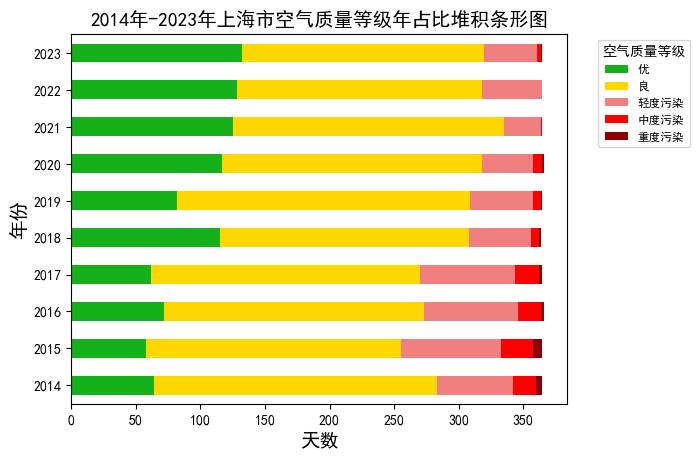

In [16]:

# 获取当前工作目录
script_dir = os.getcwd()

# 读取总统计结果CSV文件
result_path = os.path.join(script_dir, '总统计结果.csv')
merged_result = pd.read_csv(result_path)

# 按城市过滤数据，选择上海的数据
shanghai_data = merged_result[merged_result['城市'] == '上海']

# 指定中文字体为'SIMHEI'
font = FontProperties(fname=r"c:\windows\fonts\SIMHEI.ttf", size=14)

# 创建一个图表
plt.figure(figsize=(12, 6))

# 根据quality列的值对数据进行分组，并计算每个组内的天数
quality_counts = shanghai_data[['年份', '优', '良', '轻度污染', '中度污染', '重度污染']]

# 颜色映射
colors = {'优': '#15b01a', '良': '#ffd700', '轻度污染': 'lightcoral', '中度污染': '#ff0000', '重度污染': 'darkred'}

# 创建一个堆积条形图
quality_counts.set_index('年份').plot(kind='barh', stacked=True, color=[colors[col] for col in quality_counts.columns[1:]])

# 添加标签和标题
plt.ylabel('年份', fontproperties=font)
plt.xlabel('天数', fontproperties=font)
plt.title('2014年-2023年上海市空气质量等级年占比堆积条形图', fontproperties=font)

# 添加图例
plt.legend(title='空气质量等级', title_fontsize='medium', fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图表
plt.show()


### **②APache ECharts数据可视化**

> **全国省会城市AQI监测查询大屏：**

![](./data_analyse_files/大屏静态.png)

> **大屏图表动图展示：**

> + **全国省会城市实时AQI信息地图（map）**
![](./data_analyse_files/mapAQI.gif)

> + **全国省会城市年AQI动态排名图**
![](./data_analyse_files/chart1.gif)

> + **2014-2023年全国省会城市年均AQI变化图**
![](./data_analyse_files/chart2.gif)

> + **全国省会城市年空气质量等级占比图**
![](./data_analyse_files/chart3.gif)

> + **2014-2023上海市日AQI变化图表**
![](./data_analyse_files/chart4.gif)

> + **年均空气质量等级省会城市分布图**
![](./data_analyse_files/chart5.gif)

> + **AQI污染物雷达图**
![](./data_analyse_files/chart6.gif)